# Installation to run the code in this notebook (requirement file)

In [1]:
# pip install pandas numpy
# pip install ftfy
# pip install cleantext
# pip install bertopic
# pip install ipywidgets
# pip install matplotlib seaborn
# pip install nbformat plotly
# pip install --upgrade kaleido

# Importing libraries

In [1]:
# Data and number processing
import pandas as pd 
import numpy as np 

#  fix mojibake errors
from ftfy import fix_encoding

# Topic generation and text processing
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from nltk.corpus import stopwords

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Imporing modules
import os
import sys

# Add the src path to sys.path
sys.path.append(os.path.abspath('../src'))
from modules.modules import (missing_values_calculator_and_shape, 
                             text_cleaning_process, plot_topics, 
                             standardise_date)

# Data Preprocessing (EDA - Data exploratory analysis and Data Cleaning)

In [2]:
pd.set_option('display.max_rows', None)
df = pd.read_csv('../data/Dataset - EMPOLITICON NLP and ML Based Approach for Context and Emotion Classification of Political Speeches From Transcripts.csv')
df.iloc[:5]

,Country,Date,Speaker,Headline,Text_of_Speech,Designation,Running President/PM,Speech Link,Emotion,Context
0,Russia,16/07/2021,Vladimir Putin,Meeting of APEC Economic Leaders,"Madam Chair,\n\nColleagues,\n\nFirst of all, ...",President,Vladimir Putin,http://en.kremlin.ru/events/president/transcri...,OPTIMISM,DEVELOPMENT
1,Russia,2021-09-05 00:00:00,Vladimir Putin,Victory Parade on Red Square,"Citizens of Russia,\n\nDear veterans,\n\nComra...",President,Vladimir Putin,http://en.kremlin.ru/events/president/transcri...,JOY,NATIONALISM
2,Russia,2021-08-04 00:00:00,Vladimir Putin,Meeting on the results of implementing Preside...,"Good afternoon, colleagues.\n\nLet’s start.\n\...",President,Vladimir Putin,http://en.kremlin.ru/events/president/transcri...,NEUTRAL,DEVELOPMENT
3,Russia,21-11-2020,Vladimir Putin,G20 Summit,"Colleagues,\n\nThe scope of problems humanity ...",President,Vladimir Putin,http://en.kremlin.ru/events/president/transcri...,NEUTRAL,DEVELOPMENT
4,Russia,20-11-2020,Vladimir Putin,Address to participants in Nuremberg Lessons f...,"Colleagues, friends,\n\nFirst of all, I would ...",President,Vladimir Putin,http://en.kremlin.ru/events/president/transcri...,UPSET,EXTREMISM


# Checking NaN values

In [3]:
missing_values_calculator_and_shape(df)

,NAMES,NULL VALUE COUNT,NULL VALUES IN PERCENTAGES (%),DATA TYPE
0,Country,0,0.0,object
1,Date,0,0.0,object
2,Speaker,0,0.0,object
3,Headline,0,0.0,object
4,Text_of_Speech,0,0.0,object
5,Designation,0,0.0,object
6,Running President/PM,0,0.0,object
7,Speech Link,0,0.0,object
8,Emotion,0,0.0,object
9,Context,0,0.0,object


For the moment and for simplicity, only the Russian analysis would be taken into account.

## Fixing the date format

In [4]:
# Formatting
df['Date'] = pd.to_datetime(df['Date'].astype(str).apply(standardise_date))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Country               2010 non-null   object        
 1   Date                  2010 non-null   datetime64[ns]
 2   Speaker               2010 non-null   object        
 3   Headline              2010 non-null   object        
 4   Text_of_Speech        2010 non-null   object        
 5   Designation           2010 non-null   object        
 6   Running President/PM  2010 non-null   object        
 7   Speech Link           2010 non-null   object        
 8   Emotion               2010 non-null   object        
 9   Context               2010 non-null   object        
dtypes: datetime64[ns](1), object(9)
memory usage: 157.2+ KB


## Filtering to get only the Russian section

In [5]:
russian_df = df[df['Country'] == 'Russia'].reset_index(drop = True)
# russian_df.iloc[:5]
# russian_df.tail(5)

Let us compress the dataset to the speech only so we can analyse it and extract the topic from scratch

In [6]:
r_df = russian_df[['Date', 'Text_of_Speech']]
r_df.iloc[:5]

,Date,Text_of_Speech
0,2021-07-16,"Madam Chair,\n\nColleagues,\n\nFirst of all, ..."
1,2021-09-05,"Citizens of Russia,\n\nDear veterans,\n\nComra..."
2,2021-08-04,"Good afternoon, colleagues.\n\nLet’s start.\n\..."
3,2020-11-21,"Colleagues,\n\nThe scope of problems humanity ..."
4,2020-11-20,"Colleagues, friends,\n\nFirst of all, I would ..."


## Fixing mojibake errors (character-encoding errors)

In [7]:
r_df.loc[:, 'Text_of_Speech'] = r_df['Text_of_Speech'].apply(
    lambda x: fix_encoding(x) if isinstance(x, str) else x)
r_df.iloc[:5]

,Date,Text_of_Speech
0,2021-07-16,"Madam Chair,\n\nColleagues,\n\nFirst of all, ..."
1,2021-09-05,"Citizens of Russia,\n\nDear veterans,\n\nComra..."
2,2021-08-04,"Good afternoon, colleagues.\n\nLet’s start.\n\..."
3,2020-11-21,"Colleagues,\n\nThe scope of problems humanity ..."
4,2020-11-20,"Colleagues, friends,\n\nFirst of all, I would ..."


## Cleaning special characters, punctuation, and numbers

In [8]:
r_df.loc[:, 'Text_of_Speech'] = r_df['Text_of_Speech'].apply(text_cleaning_process)
r_df.iloc[:5]

,Date,Text_of_Speech
0,2021-07-16,madam chair\n\ncolleagues\n\nfirst of all i wo...
1,2021-09-05,citizens of russia\n\ndear veterans\n\ncomrade...
2,2021-08-04,good afternoon colleagues\n\nlet’s start\n\nas...
3,2020-11-21,colleagues\n\nthe scope of problems humanity h...
4,2020-11-20,colleagues friends\n\nfirst of all i would lik...


# Topic Generation

In [19]:
# Create a list of speeches
docs = r_df['Text_of_Speech'].tolist()

# Remove english stopwords with a vectorizer
standard_stopwords = list(stopwords.words('english'))

additional_stopwords = [
    'people', 'government', 'country', 'nation', 'state', 'public', 'citizen',
    'citizens', 'parliament', 'house', 'chamber', 'minister', 'leaders',
    'leader', 'party', 'parties', 'political', 'politics', 'policy', 'policies',
    'economy', 'economic', 'social', 'national', 'international', 'global',
    'community', 'communities', 'system', 'systems', 'reform', 'future',
    'today', 'tomorrow', 'yesterday', 'time', 'years', 'year', 'day', 'days',
    'new', 'old', 'great', 'good', 'bad', 'well', 'better', 'best', 'more',
    'less', 'much', 'many', 'all', 'any', 'some', 'no', 'every', 'each',
    'these', 'those', 'this', 'that', 'here', 'there', 'now', 'then', 'also',
    'just', 'only', 'very', 'really', 'even', 'indeed', 'however', 'therefore',
    'furthermore', 'moreover', 'thus', 'so', 'and', 'but', 'or', 'if', 'because',
    'as', 'while', 'when', 'where', 'how', 'what', 'which', 'who', 'whom',
    'whose', 'why', 'we', 'us', 'our', 'ours', 'they', 'them', 'their', 'theirs',
    'he', 'him', 'his', 'she', 'her', 'hers', 'it', 'its', 'you', 'your', 'yours',
    'i', 'me', 'my', 'mine', 'myself', 'ourselves', 'themselves', 'himself',
    'herself', 'itself', 'can', 'will', 'would', 'should', 'could', 'may', 'might',
    'must', 'have', 'has', 'had', 'do', 'does', 'did', 'being', 'been', 'is', 'am',
    'are', 'was', 'were', 'from', 'with', 'about', 'across', 'after', 'against',
    'along', 'among', 'around', 'at', 'before', 'behind', 'below', 'beneath',
    'beside', 'between', 'beyond', 'by', 'down', 'during', 'except', 'for', 'from',
    'in', 'inside', 'into', 'like', 'near', 'of', 'off', 'on', 'onto', 'out',
    'outside', 'over', 'past', 'round', 'through', 'to', 'toward', 'towards',
    'under', 'underneath', 'until', 'up', 'upon', 'with', 'within', 'without',
    'about', 'above', 'below', 'across', 'already', 'always', 'another', 'anywhere',
    'around', 'become', 'becomes', 'certain', 'clearly', 'come', 'comes', 'consider',
    'considering', 'continue', 'continues', 'definitely', 'despite', 'develop',
    'developed', 'developing', 'different', 'doing', 'done', 'during', 'effect',
    'effective', 'effectively', 'either', 'else', 'ensure', 'ensuring', 'example',
    'examples', 'experience', 'experiences', 'fact', 'facts', 'feel', 'feeling',
    'finally', 'first', 'follow', 'following', 'force', 'forces', 'found',
    'general', 'generally', 'give', 'given', 'goes', 'going', 'gone', 'growth',
    'happens', 'high', 'hold', 'holds', 'home', 'hope', 'important', 'include',
    'includes', 'including', 'increase', 'increased', 'indeed', 'inside',
    'instead', 'interest', 'into', 'issue', 'issues', 'keep', 'keeps', 'known',
    'large', 'larger', 'least', 'left', 'level', 'levels', 'life', 'little',
    'long', 'look', 'looks', 'made', 'make', 'makes', 'making', 'means', 'member',
    'members', 'moment', 'most', 'name', 'need', 'needs', 'never', 'next', 'once',
    'order', 'part', 'particularly', 'place', 'places', 'point', 'points', 'power',
    'present', 'presented', 'problem', 'problems', 'process', 'processes',
    'provide', 'provided', 'provides', 'rather', 'reach', 'reaches', 'reason',
    'reasons', 'recent', 'recently', 'represent', 'represents', 'require',
    'requires', 'rest', 'right', 'run', 'runs', 'say', 'says', 'second', 'see',
    'seem', 'seems', 'seen', 'sense', 'set', 'sets', 'should', 'show', 'shows',
    'side', 'since', 'small', 'solution', 'solutions', 'something', 'sometimes',
    'start', 'starts', 'still', 'strong', 'sure', 'take', 'takes', 'telling',
    'terms', 'thank', 'thanks', 'think', 'thinking', 'thought', 'thoughts',
    'through', 'told', 'total', 'towards', 'true', 'truth', 'try', 'trying',
    'type', 'types', 'understand', 'understanding', 'unit', 'units', 'until',
    'use', 'used', 'uses', 'usually', 'value', 'values', 'various', 'want',
    'wants', 'way', 'ways', 'whether', 'whole', 'why', 'wide', 'wish', 'word',
    'words', 'work', 'works', 'world', 'would', 'yet', 'across', 'along', 'around',
    'away', 'back', 'come', 'down', 'forward', 'in', 'off', 'on', 'out', 'over',
    'round', 'through', 'up', 'well', 'whatsoever'
]

full_stopwords = standard_stopwords + additional_stopwords

# Define vectorizer
vectorizer_model = CountVectorizer(stop_words=full_stopwords)

# Load a more semantic-rich embedding model
embedding_model = SentenceTransformer("msmarco-distilbert-cos-v5")

# Build BERTopic with semantic embeddings
topic_model = BERTopic(
    vectorizer_model= vectorizer_model,
    embedding_model = embedding_model,
    top_n_words     = 10,
    umap_model      = UMAP(random_state=47),
    verbose         = True
)

# Fit model
topics, probabilities = topic_model.fit_transform(docs)

2025-07-16 13:35:23,066 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/18 [00:00<?, ?it/s]

2025-07-16 13:37:19,719 - BERTopic - Embedding - Completed ✓
2025-07-16 13:37:19,720 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-16 13:37:20,608 - BERTopic - Dimensionality - Completed ✓
2025-07-16 13:37:20,609 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-16 13:37:20,622 - BERTopic - Cluster - Completed ✓
2025-07-16 13:37:20,624 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-16 13:37:20,906 - BERTopic - Representation - Completed ✓


With BERTopic, ```nr_topics``` is used for merging topics after the initial clustering, not to set the number of topics from the start. If we notice some overlaping topics, we can use it.

In [20]:
# Get topic metadata
topic_info = topic_model.get_topic_info()
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,225,-1_russia_russian_one_development,"[russia, russian, one, development, countries,...",[good afternoon dear colleagues\n\ntoday’s sta...
1,0,78,0_chechnya_republic_caucasus_chechen,"[chechnya, republic, caucasus, chechen, russia...",[dear mr president of the republic of chechnya...
2,1,44,1_military_armed_defence_drug,"[military, armed, defence, drug, security, arm...",[good afternoon colleagues\n\nduring the board...
3,2,40,2_war_victory_veterans_soviet,"[war, victory, veterans, soviet, memory, nazis...",[citizens of russia veterans comrade soldiers ...
4,3,29,3_business_russia_companies_investment,"[business, russia, companies, investment, russ...",[colleagues\n\nwe are meeting at one of our co...
5,4,27,4_russia_united_duma_election,"[russia, united, duma, election, elections, de...",[colleagues friends\ni welcome the delegates a...
6,5,23,5_local_federal_regional_regions,"[local, federal, regional, regions, council, f...",[good afternoon\n\nwe met with you not long ag...
7,6,20,6_budget_tax_development_federal,"[budget, tax, development, federal, services, ...",[colleagues\n\ntoday i signed the budget addre...
8,7,17,7_region_far_east_district,"[region, far, east, district, development, fed...",[good afternoon\n\nthis meeting in vladivostok...
9,8,15,8_foreign_russia_cooperation_relations,"[foreign, russia, cooperation, relations, inte...",[good afternoon\n\nthis meeting is taking plac...


In [21]:
len(topic_info)

13

-1 refers to all outliers and should typically be ignored. 

# Topic visualization

By extracting bigrams and their probabilities from the topic model, the creation of a focused data frame is possible for each of the 5 topics. After that, a heatmap can be generated to visualize the distribution of bigrams across the topics. This visualization will help in understanding the most significant bigrams associated with each topic and their relative importance.

Next, let's take a look at the most frequent topic that was generated:

In [12]:
# Filter out the outlier topic (-1) (Leaving it out)
topic_info_filtered = topic_info[topic_info.Topic != -1]

# Bar chart: Top 10 topics by size
top_n = 10
top_topics = topic_info_filtered.iloc[:top_n]

# Horizontal bar chart: Top 10 topics with names
fig = px.bar(
    top_topics[::-1],  # reverse for descending
    x="Count",
    y="Name",
    orientation="h",
    title=f"Top {top_n} Topics by Document Count",
    color="Count",
    color_continuous_scale="Blues",
)

fig.update_layout(
    yaxis_title="Topic",
    xaxis_title="Document Count",
    yaxis=dict(tickfont=dict(size=12)),
    plot_bgcolor="white",
)


## Let us plot the probabilities of each Topic

In [17]:
# Choose the topics to compare
topic_ids = [0, 1, 2, 3, 4]

# Generate figures
figures = plot_topics(topic_model, topic_ids)

# Show each figure
for fig in figures:
    plt.savefig(f'../images/topic_{fig.data[0].name}.png', dpi=300)
    fig.show()

<Figure size 640x480 with 0 Axes>

Now, let us see a heatmap to better understand

In [18]:
# Pending to make it a FOR LOOP

# Create a DataFrame for each topic with words and their probabilities
topic_1 = pd.DataFrame(topic_model.get_topic(0), columns=["Topic_1_word", "Topic_1_prob"])
topic_2 = pd.DataFrame(topic_model.get_topic(1), columns=["Topic_2_word", "Topic_2_prob"])
topic_3 = pd.DataFrame(topic_model.get_topic(2), columns=["Topic_3_word", "Topic_3_prob"])
topic_4 = pd.DataFrame(topic_model.get_topic(3), columns=["Topic_4_word", "Topic_4_prob"])
topic_5 = pd.DataFrame(topic_model.get_topic(4), columns=["Topic_5_word", "Topic_5_prob"])
topic_6 = pd.DataFrame(topic_model.get_topic(5), columns=["Topic_6_word", "Topic_6_prob"])

# Concatenate all topic DataFrames into a single DataFrame
topics_df = pd.concat([topic_1, 
                       topic_2, 
                       topic_3, 
                       topic_4, 
                       topic_5, 
                       topic_6], axis=1)

Visualizing the topics with a heatmap can provide insights into the distribution of bigrams across different topics. This can help in understanding which bigrams are more prevalent in certain topics and how they relate to each other.

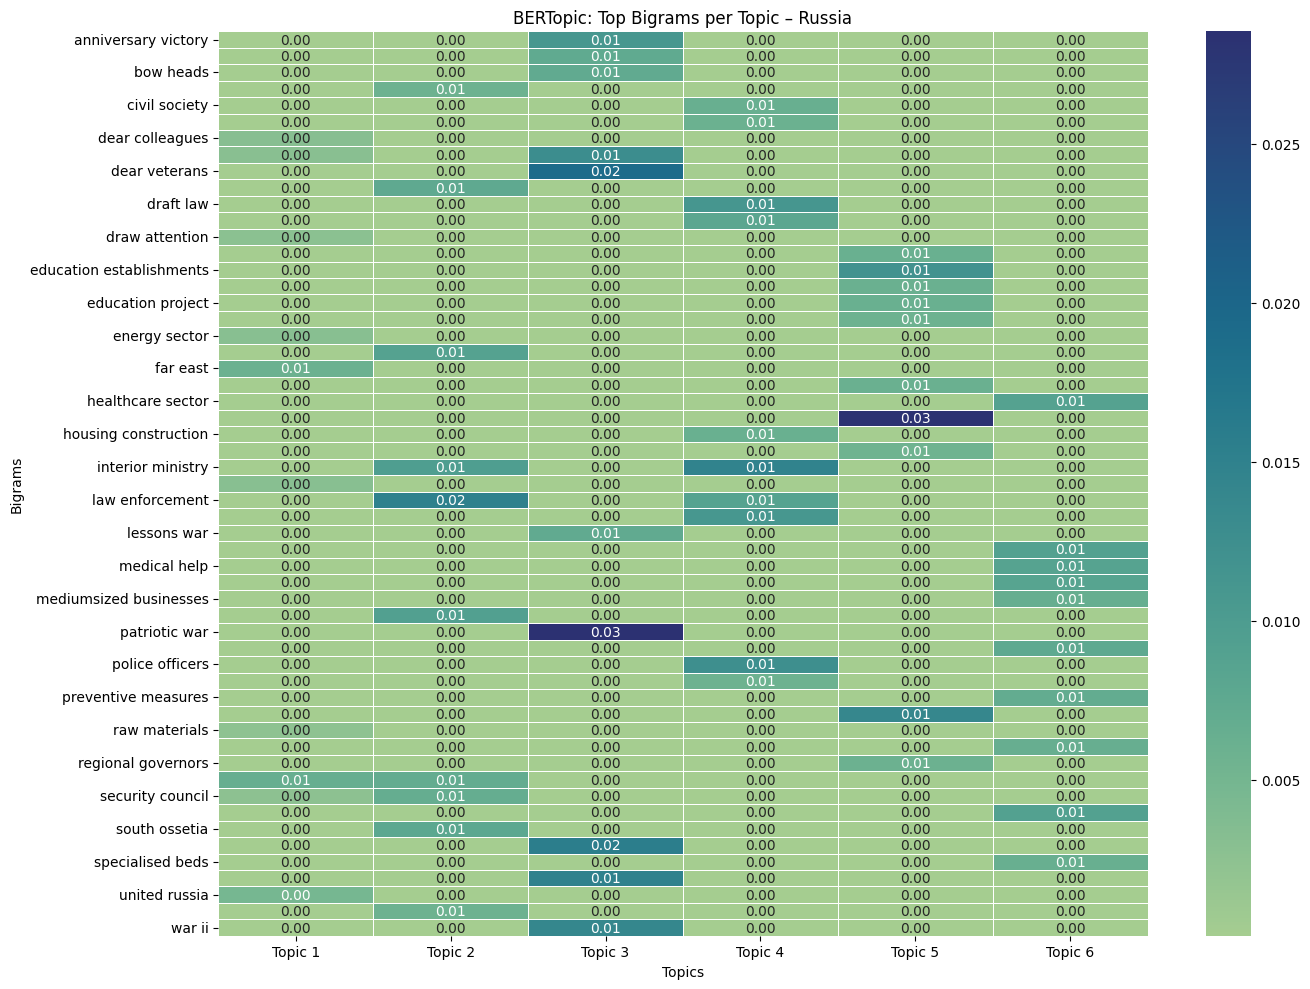

In [19]:
# Combine topics into one DataFrame
topics = []
for i in range(1, 7):
    words = topics_df[f"Topic_{i}_word"]
    probs = topics_df[f"Topic_{i}_prob"]
    temp_df = pd.DataFrame({
        'Bigram': words,
        'Topic': f'Topic {i}',
        'Prob': probs
    })
    topics.append(temp_df)

reshaped_data = pd.concat(topics)

# Pivot table: Bigram as rows, Topics as columns
pivot_table = reshaped_data.pivot(index='Bigram', columns='Topic', values='Prob').fillna(0)

# Plot heatmap
plt.figure(figsize=(14, 10))
cmap = sns.color_palette("crest", as_cmap=True)
sns.heatmap(pivot_table, cmap=cmap, linewidths=0.5, annot=True, fmt=".2f",
            cbar=True, vmin=0.0001)

# Axis labels and title
plt.title('BERTopic: Top Bigrams per Topic – Russia')
plt.xlabel('Topics')
plt.ylabel('Bigrams')
plt.tight_layout()
plt.savefig('../images/heatmap_bertopic_russia.png', dpi=300)
